The real time detection will be done using a different model and the JSON file with the current model and the weights of the neural network we will create.
a 70-100% success rate of facial recognition is satisfactory because the real-time app will use several pictures and the common emotion recognition resault to decide the emotion - in this current run we have reached 74%


In April 2023 the access to AffectNet Data set will be restored and the success rate can be reached to over 90% in the next few days we will try KDEF dataset for better results

The first section of the code manipulates the dataset of the faces photos into lists, and builds the model
all with imports at the beginning  

# First Section

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd                       #reading, writing and manipulating the data (using tables)
import numpy as np                        #Library for linear algebra and some probabiltity (raw data)
import tensorflow as tf                       
from keras.models import Sequential       #To create the sequential layer
from tensorflow.keras.callbacks import EarlyStopping

#from keras.layers.core import Flatten, Dense, Dropout     #To create the model
#from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D  #To create the model
from keras.preprocessing import image             #used for image classification
from keras.preprocessing.image import ImageDataGenerator  #used to expand the training dataset in order to improve the performance and ability of the model to generalize

from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from keras.optimizers import SGD, Adam          #To use the optimizer
from keras.utils import np_utils  

#import cv2                                #CV (computer vision)
#from google.colab import files            #To be able to upload files

In [3]:
emotion_data = pd.read_csv('/content/drive/MyDrive/fer/fer2013.csv')
new_labels_data = pd.read_csv('/content/drive/MyDrive/fer/fer2013new.csv')
print(emotion_data)
print(new_labels_data)

       emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 columns]
             Usage      Im

utilizing microsofts new labeling of fer2013 face repository to give better lables to faces

In [4]:
new_emotion = []
for i, row in new_labels_data.iterrows():
    emotion = max(row['neutral'],row['happiness'],row['surprise'],row['sadness'],row['anger'],row['disgust'],row['fear'])
    if (row['neutral']==emotion): max_index=6
    if (row['happiness']==emotion): max_index=3
    if (row['surprise']==emotion): max_index=5
    if (row['sadness']==emotion): max_index=4
    if (row['anger']==emotion): max_index=0
    if (row['disgust']==emotion): max_index=1
    if (row['fear']==emotion): max_index=2
    new_emotion.append(max_index)

Spliting the DataSet between faces to train on and faces to test accuracy with 

In [5]:
X_train = []      #train pixels
y_train = []      #train labels
X_test = []       #test pixels
y_test = []       #test label
for index, row in emotion_data.iterrows():    #iterate on each row and store it
    k = row['pixels'].split(" ")       #list of pixels, each pixel is an element
    try:
      if row['Usage'] == 'Training':    
          X_train.append(np.array(k,'float32'))    #The desired data-type for the array is 
          y_train.append(new_emotion[index])
      elif row['Usage'] == 'PublicTest':
          X_test.append(np.array(k,'float32'))
          y_test.append(new_emotion[index])
    except:
      print(f"error occured at index :{index} and row:{row}")


[array([254., 254., 254., ...,  42., 129., 180.], dtype=float32), array([156., 184., 198., ..., 172., 167., 161.], dtype=float32), array([ 69., 118.,  61., ...,  88.,  87.,  90.], dtype=float32), array([205., 203., 236., ...,  43.,  82.,  86.], dtype=float32), array([87., 79., 74., ..., 41., 34., 32.], dtype=float32), array([235., 233., 223., ...,  33.,  17.,  19.], dtype=float32), array([ 71.,  70., 104., ..., 127., 105., 108.], dtype=float32), array([176., 177., 170., ..., 130., 144., 141.], dtype=float32), array([255., 255., 255., ..., 255., 255., 255.], dtype=float32), array([126., 126., 123., ..., 130.,  97.,  78.], dtype=float32), array([180., 175., 169., ...,  32.,  32.,  33.], dtype=float32), array([ 88.,  46.,  35., ..., 229., 228., 227.], dtype=float32), array([121., 112.,  64., ...,  81.,  83.,  85.], dtype=float32), array([165., 203., 211., ..., 189., 178., 167.], dtype=float32), array([22., 28., 27., ..., 90., 81., 92.], dtype=float32), array([132., 154., 165., ...,  70., 

In [6]:
#--------------------Convert Lists to Numpy arrays------------------------------
X_train = np.array(X_train, 'float32')
y_train = np.array(y_train, 'float32')
X_test = np.array(X_test,'float32')
y_test = np.array(y_test,'float32')

#-----------------------Reshape Pixels arrays---------------------------------
#normalizing data between o and 1  
X_train -= np.mean(X_train, axis=0)  
X_train /= np.std(X_train, axis=0)  

X_test -= np.mean(X_test, axis=0)  
X_test /= np.std(X_test, axis=0) 

#reshape the numpy array to be passed to the model
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)   
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

#------------------Convert Labels array to categorial ones---------------------
#y_train= tf.keras.utils.to_categorical(y_train, num_classes=7)
#y_test = tf.keras.utils.to_categorical(y_test, num_classes=7)

y_train= np_utils.to_categorical(y_train, num_classes=7)
y_test = np_utils.to_categorical(y_test, num_classes=7)


(3589, 48, 48, 1)
<class 'numpy.ndarray'>
(28709, 48, 48, 1)
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
(28709, 7)
<class 'numpy.ndarray'>


In [7]:
model = Sequential()

model.add(Conv2D(input_shape=(X_train.shape[1:]),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 128)      0         
 2D)                                                    

#KDEF dataset

In [13]:
import os
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.utils import load_img,img_to_array

kdef = []
lables = []
pics = []
for i in range(0,6):
    # set the path to the folder of pictures
    folder_path = '/content/drive/MyDrive/fer/KDEF/kdef/'+str(i)

    # get a list of all the files in the folder
    pics = os.listdir(folder_path)
    
    # iterate through the image files
    for pic in pics:
          img_data = load_img(pic, target_size = (48, 48))        #load the image from the directory
          img_data = img_to_array(pic)                            #convert the image to a Numpy array
          img_data = tf.image.rgb_to_grayscale(img_data)
          kdef.append(img_data)
          lables.append(i)

print(kdef)
print(lables)

FileNotFoundError: ignored

The seacond section is for controlled training of the model and testing the model on test dataset and private pictures

# Training KDEF

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
batch = 32 #number of images to be procces in a single batch
epoch = 10 #how many times the model will train on the csv file
es = EarlyStopping(monitor="val_accuracy", patience=2, mode="max",restore_best_weights=True)

history = model.fit(kdef,lables,batch_size= batch,epochs= epoch,verbose=1,callbacks=[es],shuffle=True)


Epoch 1/10
898/898 [==============================] - 50s 44ms/step - loss: 1.5647 - accuracy: 0.3875 - val_loss: 1.3934 - val_accuracy: 0.5180
Epoch 2/10
898/898 [==============================] - 41s 45ms/step - loss: 1.1973 - accuracy: 0.5808 - val_loss: 1.0352 - val_accuracy: 0.6417
Epoch 3/10
898/898 [==============================] - 41s 46ms/step - loss: 0.9993 - accuracy: 0.6468 - val_loss: 0.9294 - val_accuracy: 0.6765
Epoch 4/10
898/898 [==============================] - 41s 46ms/step - loss: 0.8609 - accuracy: 0.6907 - val_loss: 0.8687 - val_accuracy: 0.6902
Epoch 5/10
898/898 [==============================] - 41s 45ms/step - loss: 0.7385 - accuracy: 0.7329 - val_loss: 0.8338 - val_accuracy: 0.7080
Epoch 6/10
898/898 [==============================] - 42s 47ms/step - loss: 0.6167 - accuracy: 0.7770 - val_loss: 0.7995 - val_accuracy: 0.7292
Epoch 7/10
898/898 [==============================] - 43s 48ms/step - loss: 0.5051 - accuracy: 0.8202 - val_loss: 0.8033 - val_accuracy:

In [ ]:
loss_and_metrics = model.evaluate(X_test,y_test)
print(loss_and_metrics)


113/113 [==============================] - 2s 13ms/step - loss: 0.8033 - accuracy: 0.7406
[0.8032772541046143, 0.7405962944030762]


1/1 [==============================] - 0s 22ms/step


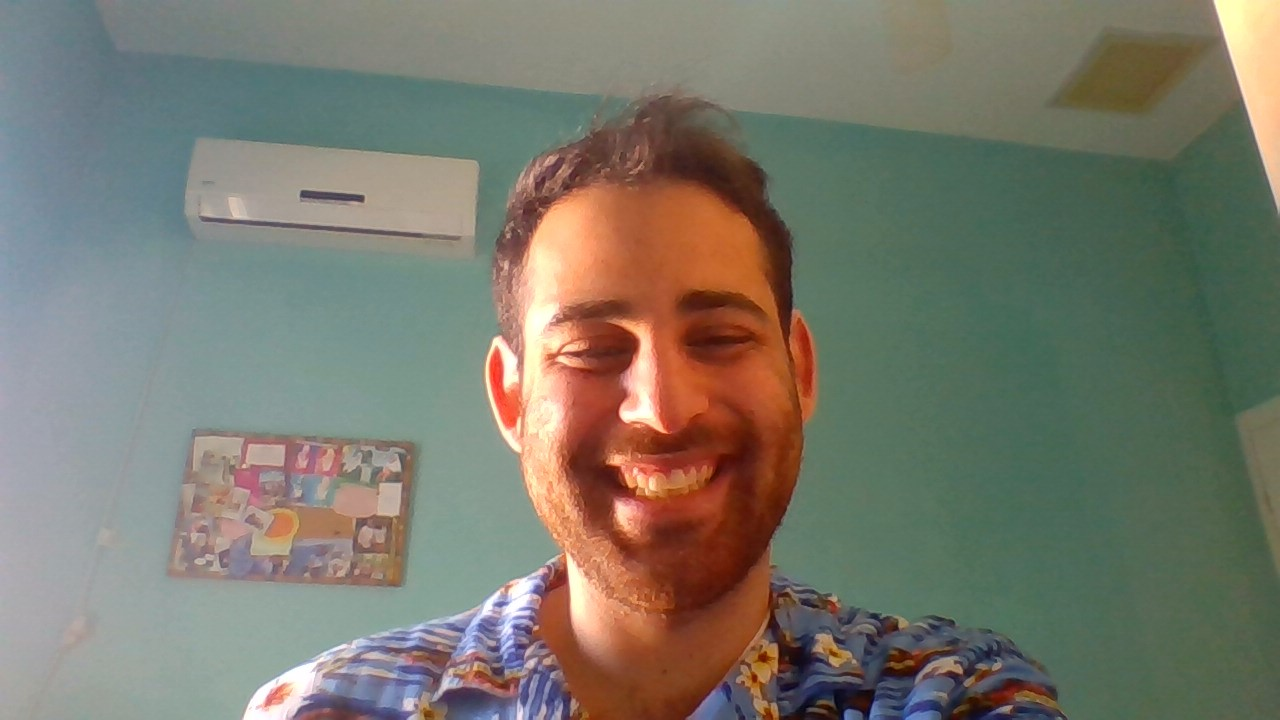



5 = surprise
1/1 [==============================] - 0s 21ms/step


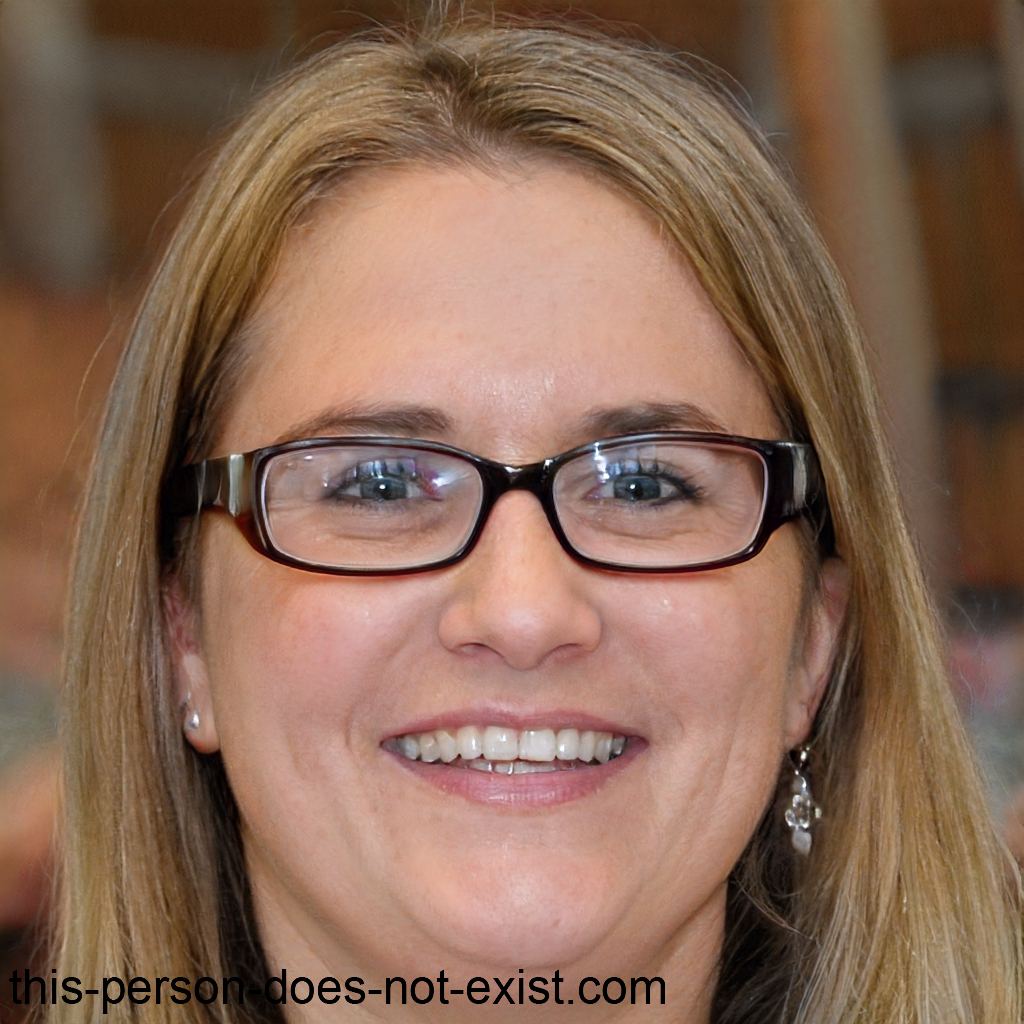



3 = happy
1/1 [==============================] - 0s 28ms/step


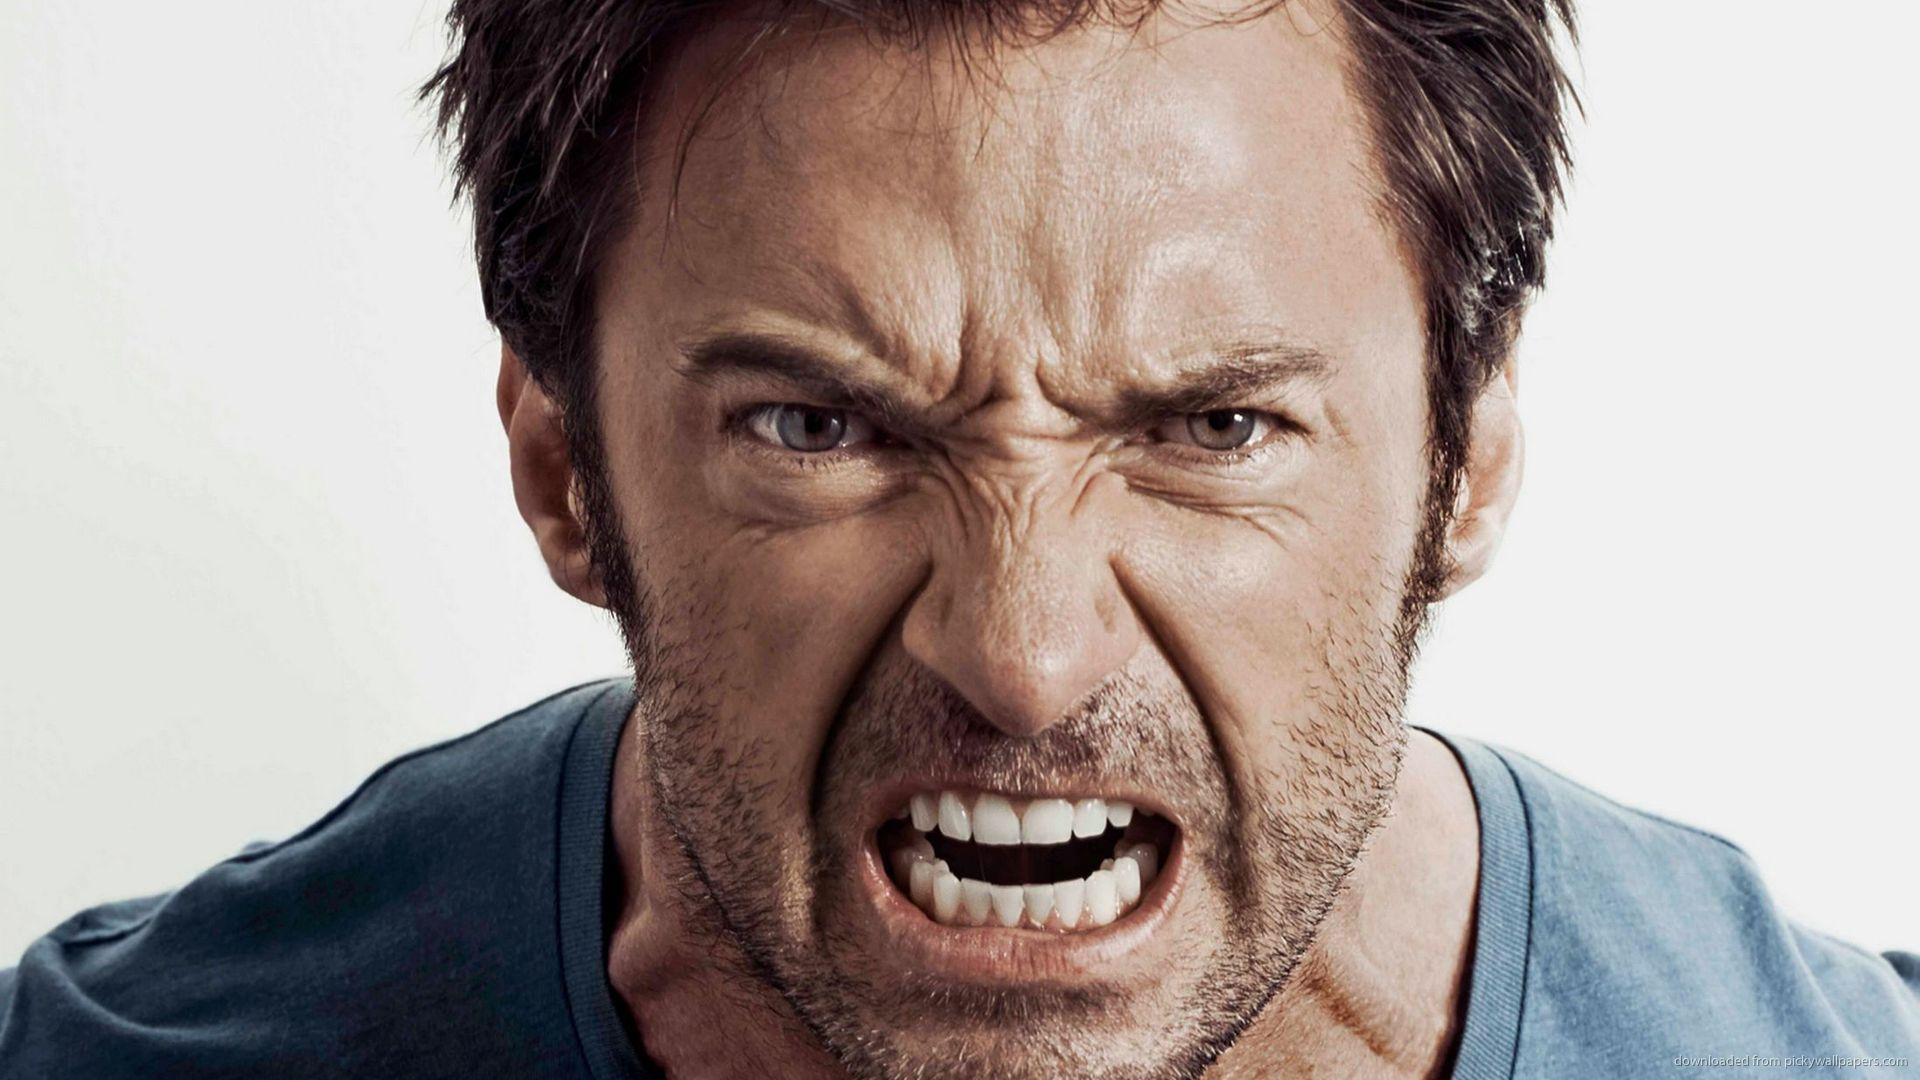



5 = surprise
1/1 [==============================] - 0s 27ms/step


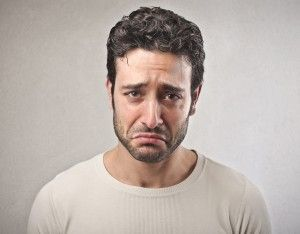



5 = surprise
1/1 [==============================] - 0s 44ms/step


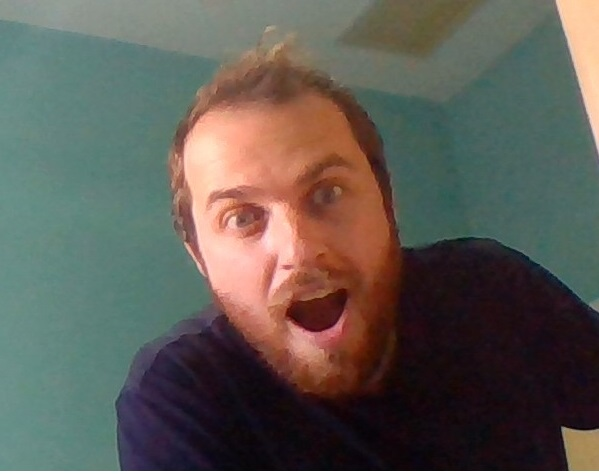



5 = surprise
1/1 [==============================] - 0s 42ms/step


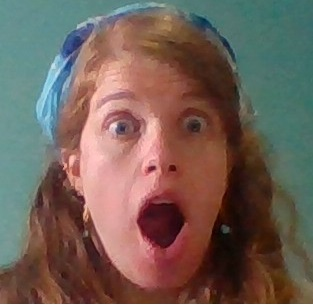



5 = surprise
1/1 [==============================] - 0s 40ms/step


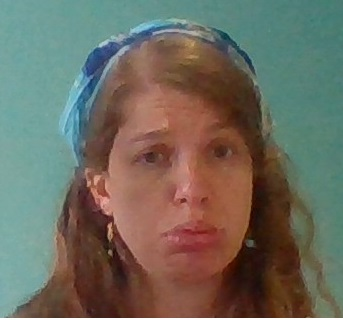



5 = surprise
1/1 [==============================] - 0s 33ms/step


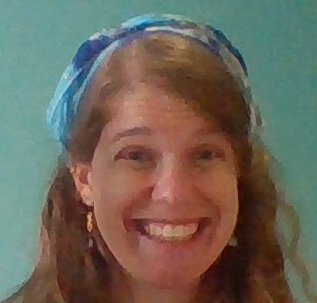



5 = surprise


In [ ]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.utils import load_img,img_to_array

TGREEN =  '\033[1;37;42m'
TRED =    '\033[1;37;41m'
TYELLOW = '\033[0;43m'

for i in range (1,9):
  img_directory = '/content/drive/MyDrive/fer (1)/'+str(i)+'.jpg'
  img_data = load_img(img_directory, target_size = (48, 48))   #load the image from the directory
  img_data = img_to_array(img_data)                            #convert the image to a Numpy array
  img_data = tf.image.rgb_to_grayscale(img_data)

  #print(img_data.shape)
  #img_data = np.array(img_data, 'float32')
  #img_data.resize(48,48,1)
  #print(img_data.shape)
  img_data = np.expand_dims(img_data, axis = 0)                     #expands the array by inserting a new axis at the specified position.
  #print(img_data.shape)

  classify = model.predict(img_data)
  display(Image(img_directory,width= 150, height=150))
  print("\n")
  max_index = np.argmax(classify[0])
  emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
  emotion_prediction = emotion_detection[max_index]  
  
  if(max_index == 3 or max_index == 5):
    print(TGREEN + str(max_index) + ' = ' +  emotion_prediction)
  elif(max_index == 4 or max_index == 2 or max_index == 0):
    print(TRED + str(max_index) + ' = ' +  emotion_prediction)
  else:
    print(TYELLOW + str(max_index) + ' = ' +  emotion_prediction)



Third section is for saving the weights of the neural network into a file so we wouldn't have to train the model every time we use the face recognition

# Training

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
batch = 32 #number of images to be procces in a single batch
epoch = 10 #how many times the model will train on the csv file
es = EarlyStopping(monitor="val_accuracy", patience=2, mode="max",restore_best_weights=True)

history = model.fit(X_train,y_train,batch_size= batch,epochs= epoch,verbose=1,callbacks=[es],validation_data=(X_test, y_test),shuffle=True)


Epoch 1/10
898/898 [==============================] - 50s 44ms/step - loss: 1.5647 - accuracy: 0.3875 - val_loss: 1.3934 - val_accuracy: 0.5180
Epoch 2/10
898/898 [==============================] - 41s 45ms/step - loss: 1.1973 - accuracy: 0.5808 - val_loss: 1.0352 - val_accuracy: 0.6417
Epoch 3/10
898/898 [==============================] - 41s 46ms/step - loss: 0.9993 - accuracy: 0.6468 - val_loss: 0.9294 - val_accuracy: 0.6765
Epoch 4/10
898/898 [==============================] - 41s 46ms/step - loss: 0.8609 - accuracy: 0.6907 - val_loss: 0.8687 - val_accuracy: 0.6902
Epoch 5/10
898/898 [==============================] - 41s 45ms/step - loss: 0.7385 - accuracy: 0.7329 - val_loss: 0.8338 - val_accuracy: 0.7080
Epoch 6/10
898/898 [==============================] - 42s 47ms/step - loss: 0.6167 - accuracy: 0.7770 - val_loss: 0.7995 - val_accuracy: 0.7292
Epoch 7/10
898/898 [==============================] - 43s 48ms/step - loss: 0.5051 - accuracy: 0.8202 - val_loss: 0.8033 - val_accuracy:

In [ ]:
loss_and_metrics = model.evaluate(X_test,y_test)
print(loss_and_metrics)


113/113 [==============================] - 2s 13ms/step - loss: 0.8033 - accuracy: 0.7406
[0.8032772541046143, 0.7405962944030762]


1/1 [==============================] - 0s 22ms/step


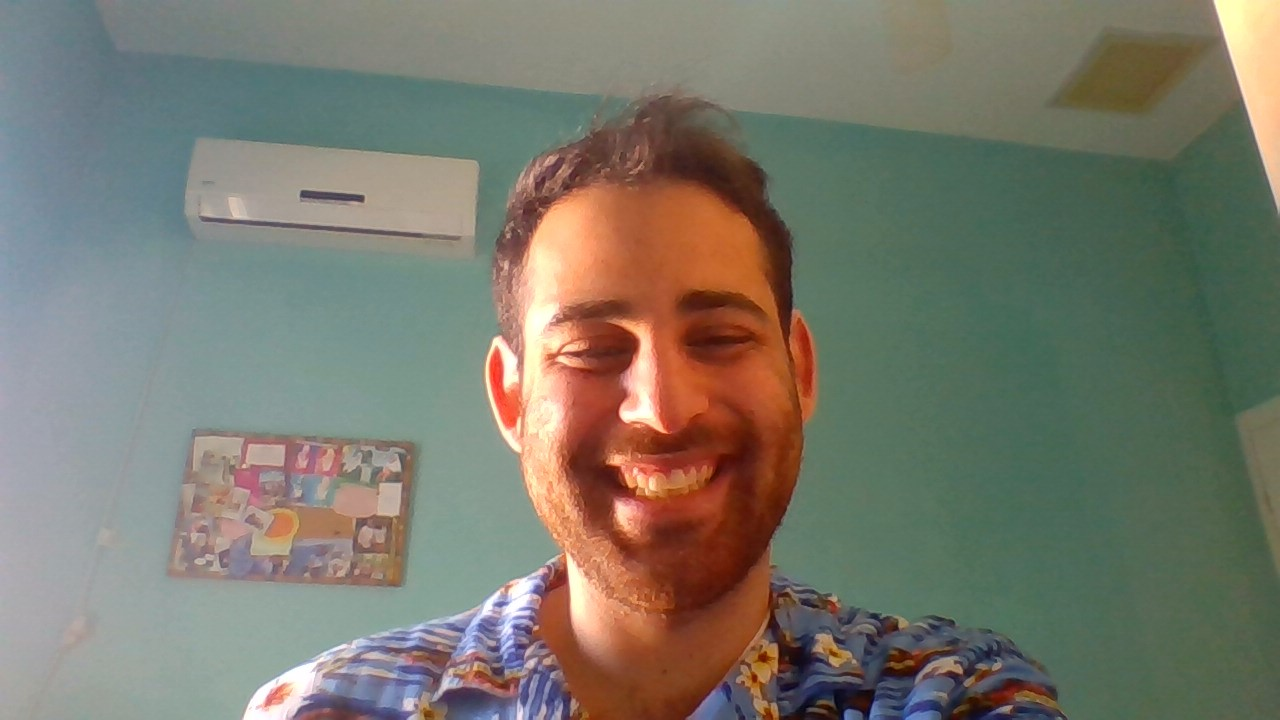



5 = surprise
1/1 [==============================] - 0s 21ms/step


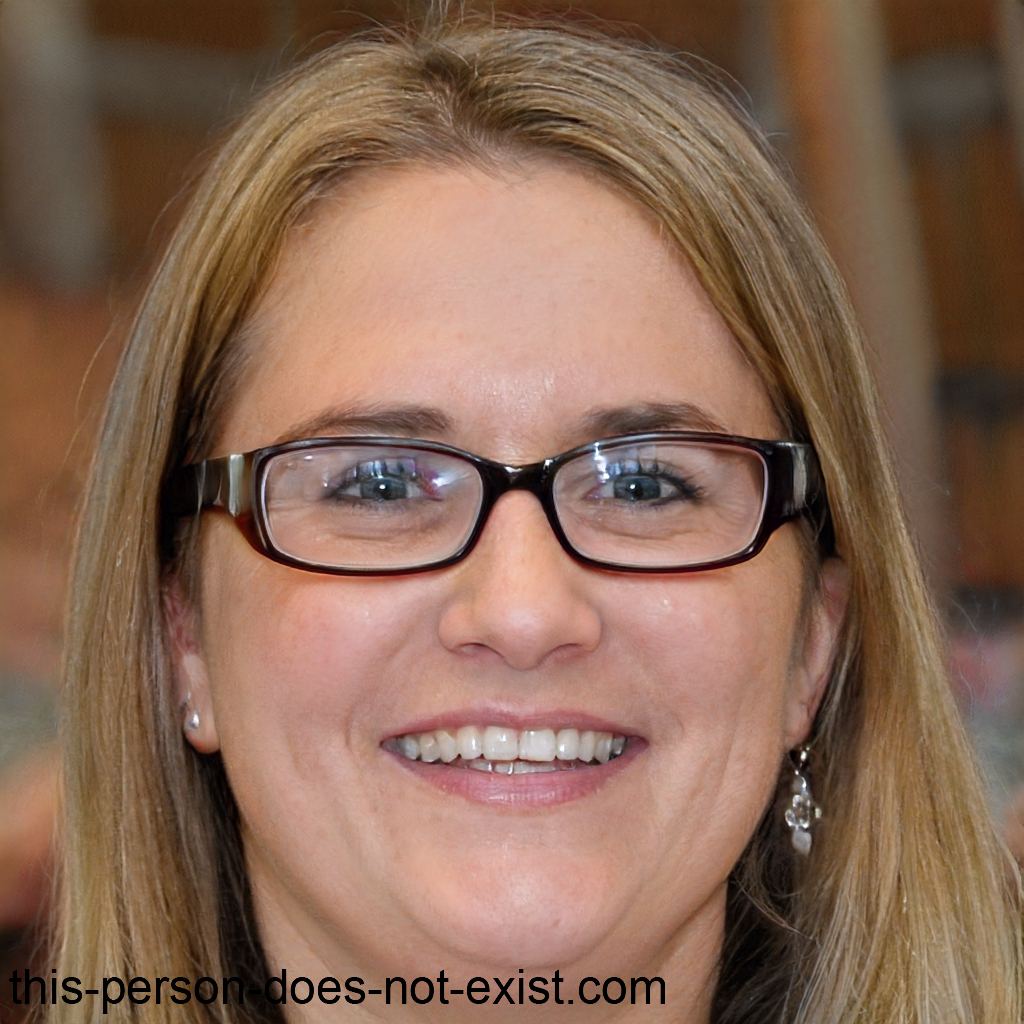



3 = happy
1/1 [==============================] - 0s 28ms/step


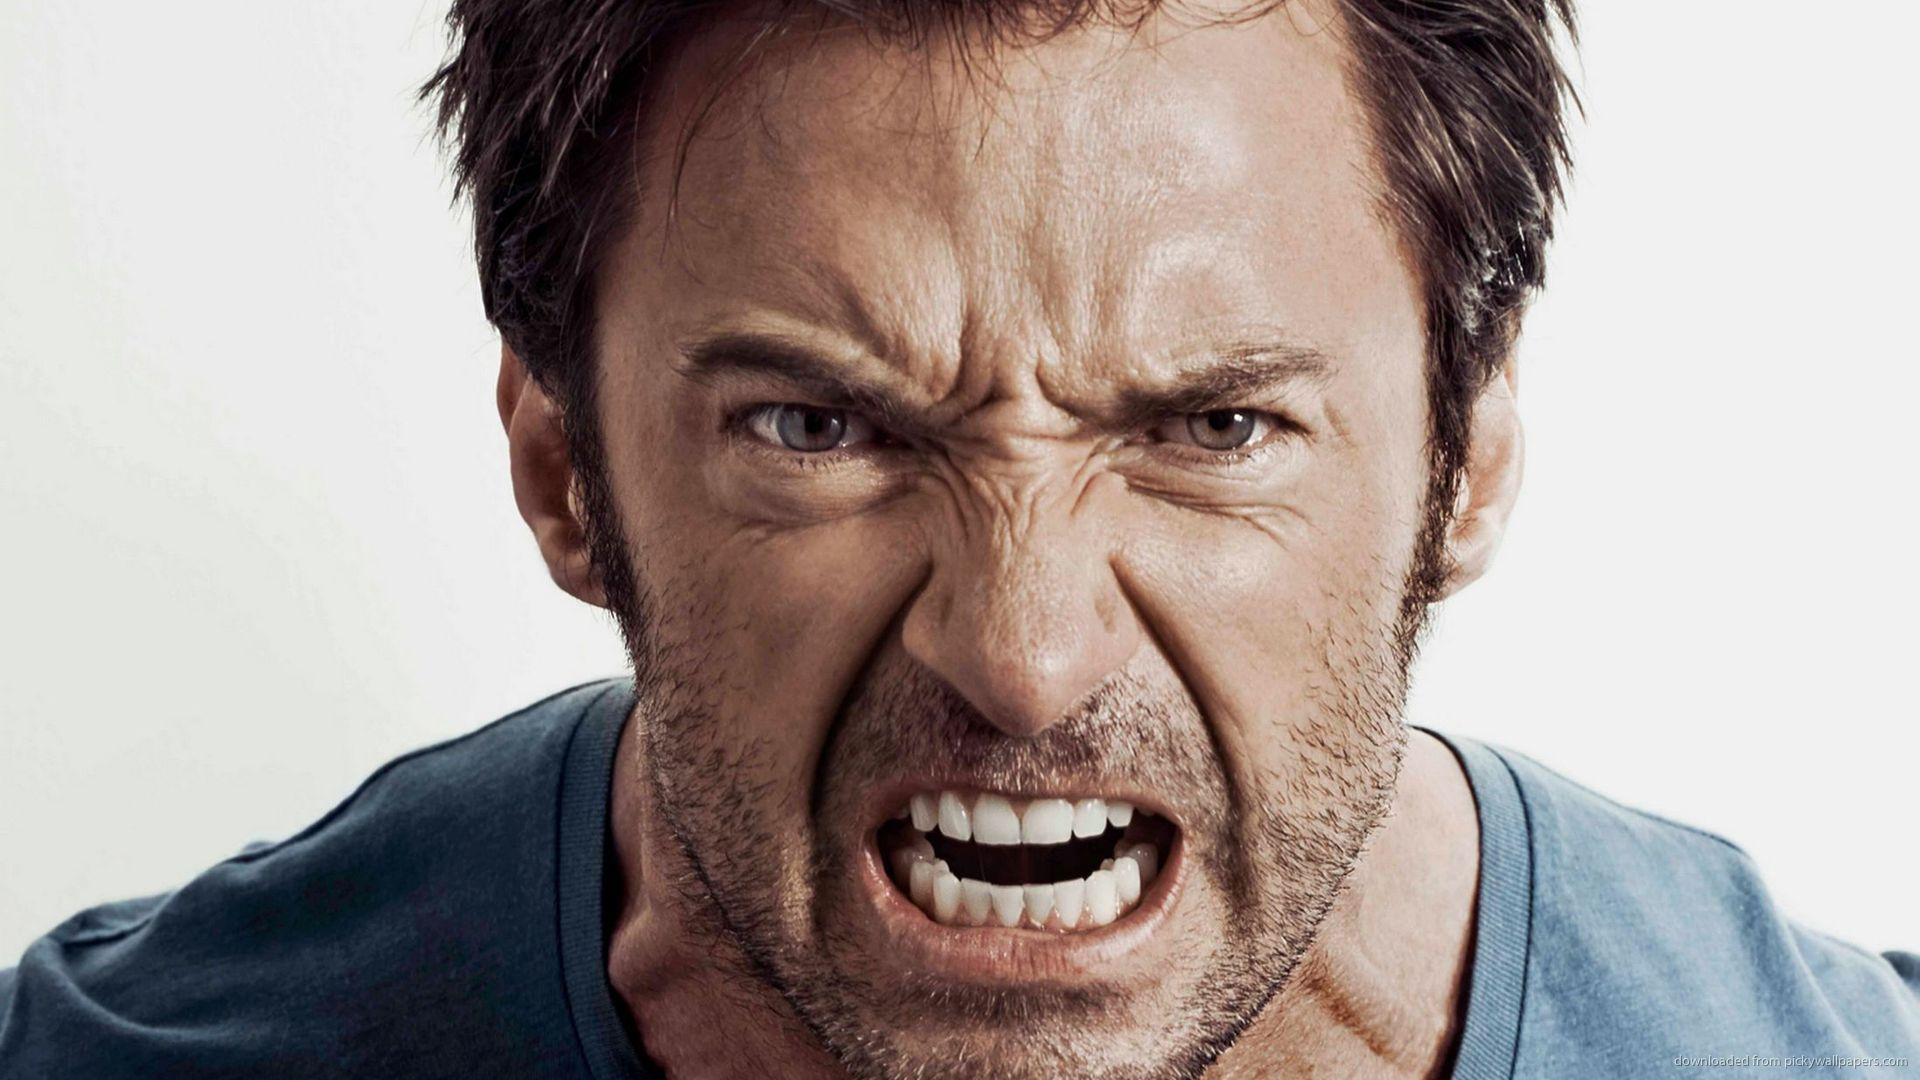



5 = surprise
1/1 [==============================] - 0s 27ms/step


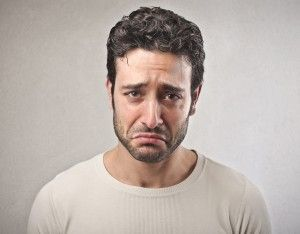



5 = surprise
1/1 [==============================] - 0s 44ms/step


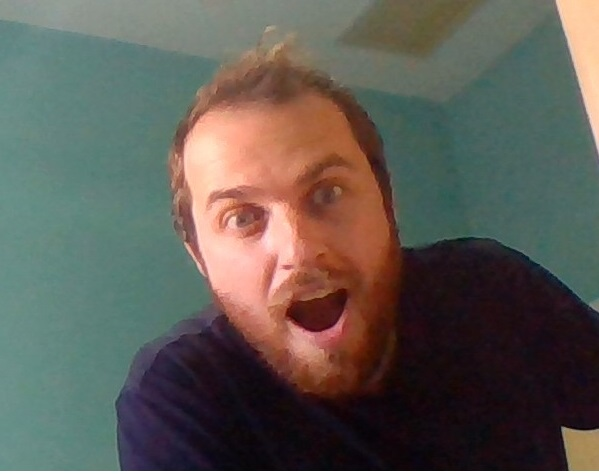



5 = surprise
1/1 [==============================] - 0s 42ms/step


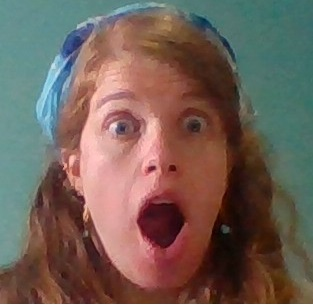



5 = surprise
1/1 [==============================] - 0s 40ms/step


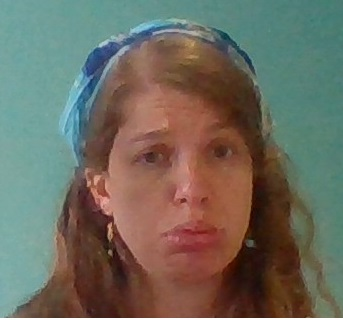



5 = surprise
1/1 [==============================] - 0s 33ms/step


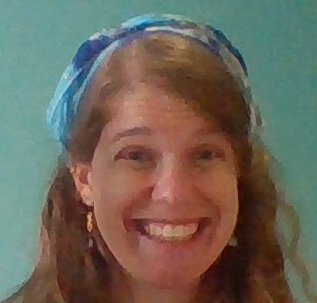



5 = surprise


In [ ]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.utils import load_img,img_to_array

TGREEN =  '\033[1;37;42m'
TRED =    '\033[1;37;41m'
TYELLOW = '\033[0;43m'

for i in range (1,9):
  img_directory = '/content/drive/MyDrive/fer (1)/'+str(i)+'.jpg'
  img_data = load_img(img_directory, target_size = (48, 48))   #load the image from the directory
  img_data = img_to_array(img_data)                            #convert the image to a Numpy array
  img_data = tf.image.rgb_to_grayscale(img_data)

  #print(img_data.shape)
  #img_data = np.array(img_data, 'float32')
  #img_data.resize(48,48,1)
  #print(img_data.shape)
  img_data = np.expand_dims(img_data, axis = 0)                     #expands the array by inserting a new axis at the specified position.
  #print(img_data.shape)

  classify = model.predict(img_data)
  display(Image(img_directory,width= 150, height=150))
  print("\n")
  max_index = np.argmax(classify[0])
  emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
  emotion_prediction = emotion_detection[max_index]  
  
  if(max_index == 3 or max_index == 5):
    print(TGREEN + str(max_index) + ' = ' +  emotion_prediction)
  elif(max_index == 4 or max_index == 2 or max_index == 0):
    print(TRED + str(max_index) + ' = ' +  emotion_prediction)
  else:
    print(TYELLOW + str(max_index) + ' = ' +  emotion_prediction)



Third section is for saving the weights of the neural network into a file so we wouldn't have to train the model every time we use the face recognition

# Saving the model

We will serialize the model to JSON and save the model's weights in a hd5 file, so we can use it to make predictions directly without retraining the model everytime.



In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)
  model.save_weights("model.h5")

print("Saved model to disk - file can be located in the colab notebook inside 'content' folder")

Saved model to disk - file can be located in the colab notebook inside 'content' folder
